# Versione scalare della simulazione

In [1]:
from utils import *
from matplotlib import pyplot as plt
import numpy as np
#from time import time
#from matplotlib.animation import FuncAnimation
#import matplotlib.gridspec as gridspec

In [2]:
%matplotlib widget
plt.close('all')

La versione scalare deve definire le conduttanze a partire dal valore assegnato ai pixel, quindi serve un nuovo mesher con un metodo _compute_conductance adatto

In [3]:
class ScalarMesher(GridMesher):
    def __init__(self, film_map, conductance_func):
        self.conductance_func = conductance_func
        super().__init__(film_map, resistances=None) 
    
    def _compute_conductance(self, val_a, val_b):
        """
        Internal use method to compute the conductance between two adjacent cells based on their scalar values using the provided conductance function.
        """
        return self.conductance_func(val_a, val_b)


Il solver dovrebbe funzionare, ammesso di sostituire la creazione di un Mesher con uno ScalarMesher nel init

In [4]:
class ScalarSolver(Solver):
    def __init__(self, film_map, conductance_func, split_size=50):

        self.mesher = ScalarMesher(film_map, conductance_func)
        self.split_size = split_size
        self.shape = film_map.shape

        self.n_chunks_y = (self.shape[0] + split_size - 1) // split_size
        self.n_chunks_x = (self.shape[1] + split_size - 1) // split_size

        self.sub_networks = [None] * (self.n_chunks_y * self.n_chunks_x)    # Original local networks
        self.reduced_networks = [None] * (self.n_chunks_y * self.n_chunks_x)    # Reduced networks
        
        self.coarse_network = None
        self.full_solution = None
        
        self._build_hierarchy()

In [5]:
class ScalarAnalysis(ElectricalAnalysis):
    def __init__(self, solver):
        super().__init__(solver)
    
    def compute_maps(self):
        maps = super().compute_maps()
        
        # compute the gradients needed fo the flux function
        self.grad_P = np.gradient(maps['power_density'])
        maps['grad_P_x'] = self.grad_P[0]
        maps['grad_P_y'] = self.grad_P[1]

        return maps

La grossa differenza è nella simulazione fisica, che sostituisce le regole di evoluzione temporale con un'equazione di continuità:

$$ \frac{\partial n}{\partial t} + \nabla \cdot J = 0 $$

Il campo vettoriale J funge da flusso e dipende da 3 contributi:

- Contributo elettrico $ J_e \propto \vec{E} $
- Contributo di potenza $ J_p \propto -\nabla P $
- Diffusione $ J_d \propto -\nabla \rho$

La funzione specifica che lega il flusso alle grandezze dovrebbe essere lasciata come parametro, in modo da poterla facilmente cambiare

In [ ]:
class ScalarSimulation(Simulation):
    def __init__(self, film_map, conductance_func=None, flux_func=None, split_size=50, dbg=False):
        self.conductance_func = conductance_func if conductance_func is not None else self.default_conductance_func
        self.flux_func = flux_func if flux_func is not None else self.default_flux_func
        
        self.solver = ScalarSolver(film_map, self.conductance_func, split_size)
        self.analysis = ScalarAnalysis(self.solver)
        self.film_map = film_map.astype(float)
        self.maps = None
    
    def default_flux_func(self, rho_L, rho_R, E, P_avg, grad_P):
        """
        Default flux function that computes the mass flux based on the local densities, electric field, power density, and their gradients.
        This is a simple example and can be replaced with a more complex function as needed.
        """
        
        """mu_0 = 1.0  # Base mobility
        gamma = 0.1   # Exponent coeffifient
        P_ref = 1.0  # Reference power density for scaling
        mobility = mu_0 * np.exp(gamma * (np.sum(P_avg) / (P_ref * P_avg.size)))  # Diffusion coefficient that increases with power density"""

        E_flux = mobility * E  # Drift flux component
        D_flux = mobility * (rho_R - rho_L)  # Diffusion flux component
        P_flux = mobility * grad_P  # Power-driven flux component

        return E_flux + D_flux + P_flux
    
    def default_conductance_func(self, val_a, val_b, k=1.0):
        """
        Default conductance function that computes the conductance between two adjacent cells based on their scalar values.
        This is a simple example and can be replaced with a more complex function as needed.
        """
        return k * (val_a + val_b) / 2.0  # Average value as conductance, scaled by k

    def _compute_mass_fluxes(self, V_map, P_map):
        """
        Compute the mass fluxes on the links between nodes based on the local densities, electric field, power density, and their gradients using the provided flux function.
        """

        rho = self.film_map
        #maps = self.analysis.compute_maps()

        #grad_P_y = maps['grad_P_y']
        #grad_P_x = maps['grad_P_x']

        # --- HORIZONTAL LINKS ---
        rho_L = rho[:, :-1]
        rho_R = rho[:, 1:]
        
        E_x = -(V_map[:, 1:] - V_map[:, :-1]) 
        
        # Avg power density on the link
        P_avg_x = 0.5 * (P_map[:, 1:] + P_map[:, :-1])

        # P gradient on the link
        grad_P_x = P_map[:, 1:] - P_map[:, :-1]
        
        # Density gradient on the link
        grad_rho_x = rho_R - rho_L
        
        # Compute the X flux using the parametric function
        # Pass the sliced arrays. The function must handle numpy arrays.
        J_x_internal = self.flux_func(rho_L, rho_R, E_x, P_avg_x, grad_P_x)  # Pass None for gradients not used in this direction


        # --- VERTICAL LINKS (Y DIRECTION) ---
        # Nodes above (i, j) and below (i+1, j)
        rho_U = rho[:-1, :]
        rho_D = rho[1:, :]
        
        # Electric field E_y = -dV/dy
        E_y = -(V_map[1:, :] - V_map[:-1, :])
        
        # Avg power density
        P_avg_y = 0.5 * (P_map[1:, :] + P_map[:-1, :])

        # P gradient on the link
        grad_P_y = P_map[1:, :] - P_map[:-1, :]
        
        # Vertical gradient
        grad_rho_y = rho_D - rho_U
        
        # Compute the Y flux using the parametric function
        J_y_internal = self.flux_func(rho_U, rho_D, E_y, P_avg_y, grad_P_y)  # Pass None for gradients not used in this direction

        return J_x_internal, J_y_internal
    
    def _evolve_step(self, dt, bias_v=1.0):
        """
        Perform a single time step of the simulation by computing the electric potential, power density, mass fluxes, and updating the film map based on the divergence of the fluxes.
        """

        electrodes, grounds, all_bound = self.get_electrodes_coords()
        bound_values = np.concatenate((np.full(len(electrodes), bias_v), np.zeros(len(grounds))))
        self.solver.solve(all_bound, bound_values)
        
        elec_maps = self.analysis.compute_maps()
        V_map = self.solver.full_solution
        P_map = elec_maps['power_density']
        
        J_x_int, J_y_int = self._compute_mass_fluxes(V_map, P_map)
        
        # Pad the arrays to keep the original shape for divergence calculation
        J_x_pad = np.pad(J_x_int, ((0, 0), (1, 1)), mode='constant', constant_values=0)
        J_y_pad = np.pad(J_y_int, ((1, 1), (0, 0)), mode='constant', constant_values=0)
        
        # Divergence
        div_x = J_x_pad[:, 1:] - J_x_pad[:, :-1]
        div_y = J_y_pad[1:, :] - J_y_pad[:-1, :]
        divergence = div_x + div_y
        
        # time integration
        self.film_map -= divergence * dt
        
        #self.film_map = np.clip(self.film_map, 0.0, 1.0)

        maps = self.solve_all(all_bound, bound_values)
        #maps['potential'] = V_map
        maps["film"] = self.film_map
        self.maps = maps
        
        # build updated solver and analysis with the new film map
        self.solver = ScalarSolver(self.film_map, self.conductance_func, 
                                   split_size=self.solver.split_size)
        self.analysis = ElectricalAnalysis(self.solver)

        return maps

    def solve_all(self, bound_coords, bound_values):
        out = super().solve_all(bound_coords, bound_values)
        self.grad_P = np.gradient(self.maps['power_density'])
        return out


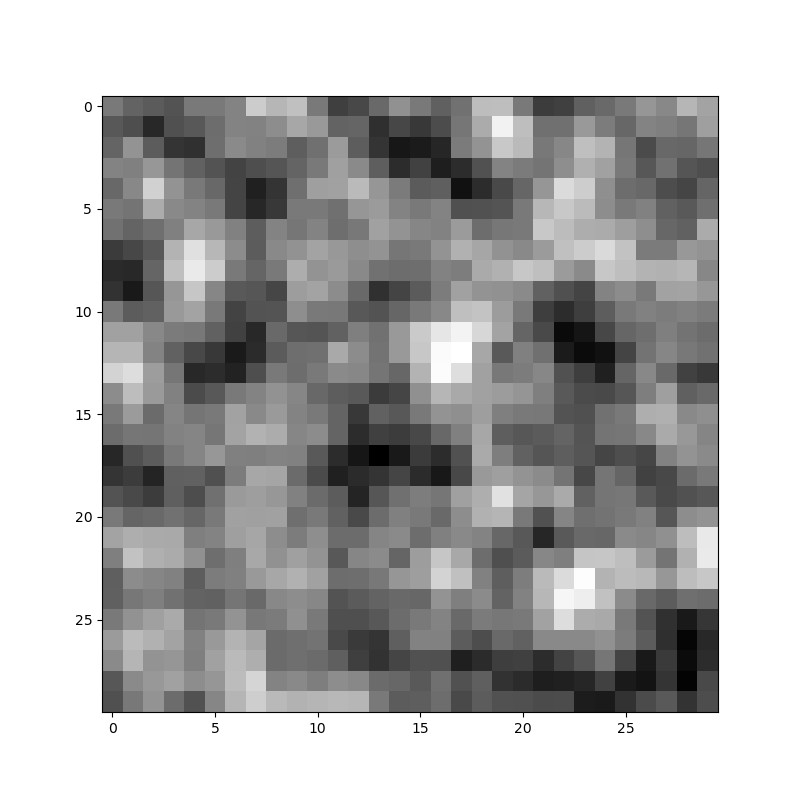

In [7]:
size = 30
scale = 5
x, y = np.meshgrid(np.arange(size), np.arange(size))
seed = None

if seed is None:
    seed = np.random.randint(0, 100)

film_map = np.vectorize(lambda i, j: pnoise2(i / scale, j / scale, octaves=6, base=seed))(x, y)
film_map = (film_map - film_map.min()) / (film_map.max() - film_map.min())  # Normalize to [0, 1]
sim = ScalarSimulation(film_map, split_size=50, dbg=True)

electrodes, grounds, all_coords = sim.get_electrodes_coords()

V_bias = np.zeros(all_coords.shape[0])
V_bias[0 : electrodes.shape[0]] = 1.0  # Set voltage at electrodes to 1V
V_bias[electrodes.shape[0] : ] = 0.0  # Set voltage at grounds to 0V

map = sim.solve_all(all_coords, V_bias)

fig, axs = plt.subplots(1, 1, figsize=(8, 8))
axs.imshow(sim.film_map, cmap='gray')

plt.show()

In [8]:
steps = 10
dt = 0.001
maps = []
for step in range(steps):
    map = sim._evolve_step(dt, bias_v=1.0)
    maps.append(map)

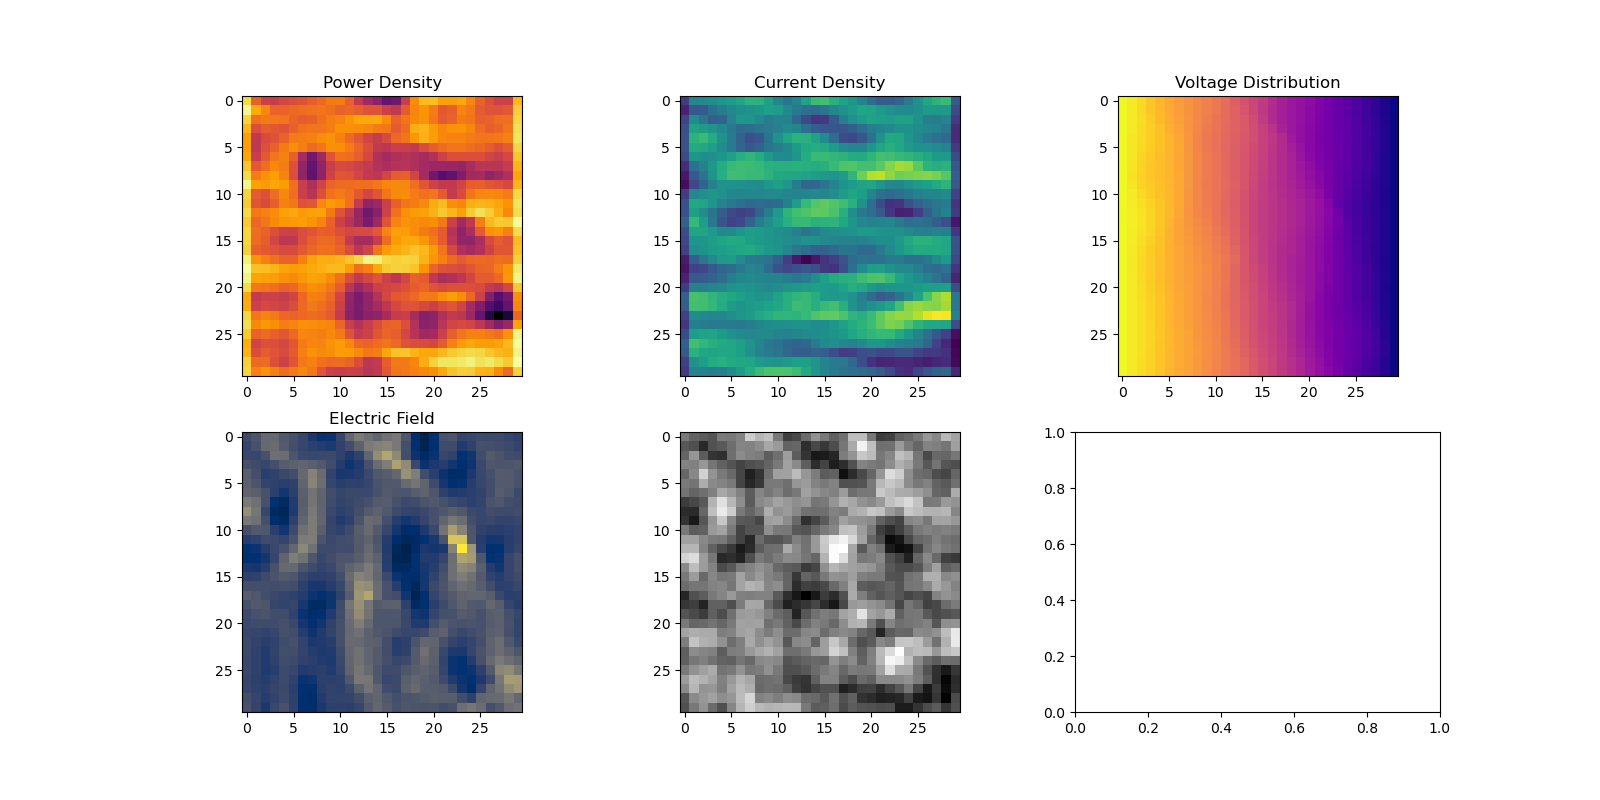

In [9]:
map = maps[0]

P_map = map["power_density"]
J_map = map["current_density"]
V_map = map["voltage"]
E_map = map["E_field"]

fig, axs = plt.subplots(2, 3, figsize=(16, 8))
axs = axs.flat

im0 = axs[0].imshow(P_map, cmap='inferno')
#plot_on_film_map(film_map_perlin, P_map, ax=axs[0], colorbar=True, log_scale=True, percentile=30, cmap_name='inferno')
axs[0].set_title('Power Density')

im2 = axs[1].imshow(J_map, cmap='viridis')
#plot_on_film_map(film_map_perlin, J_map, ax=axs[1], colorbar=True, log_scale=True, percentile=30, cmap_name='magma')
axs[1].set_title('Current Density')

im3 = axs[2].imshow(V_map, cmap='plasma')
#plot_on_film_map(film_map_perlin, V_map, ax=axs[2], colorbar=True)
axs[2].set_title('Voltage Distribution')

im4 = axs[3].imshow(E_map, cmap='cividis')
#plot_on_film_map(film_map_perlin, E_map, ax=axs[3], colorbar=True, log_scale=True, percentile=30, cmap_name='cividis')
axs[3].set_title('Electric Field')

im5 = axs[4].imshow(map["film"], cmap='gray')

plt.show()

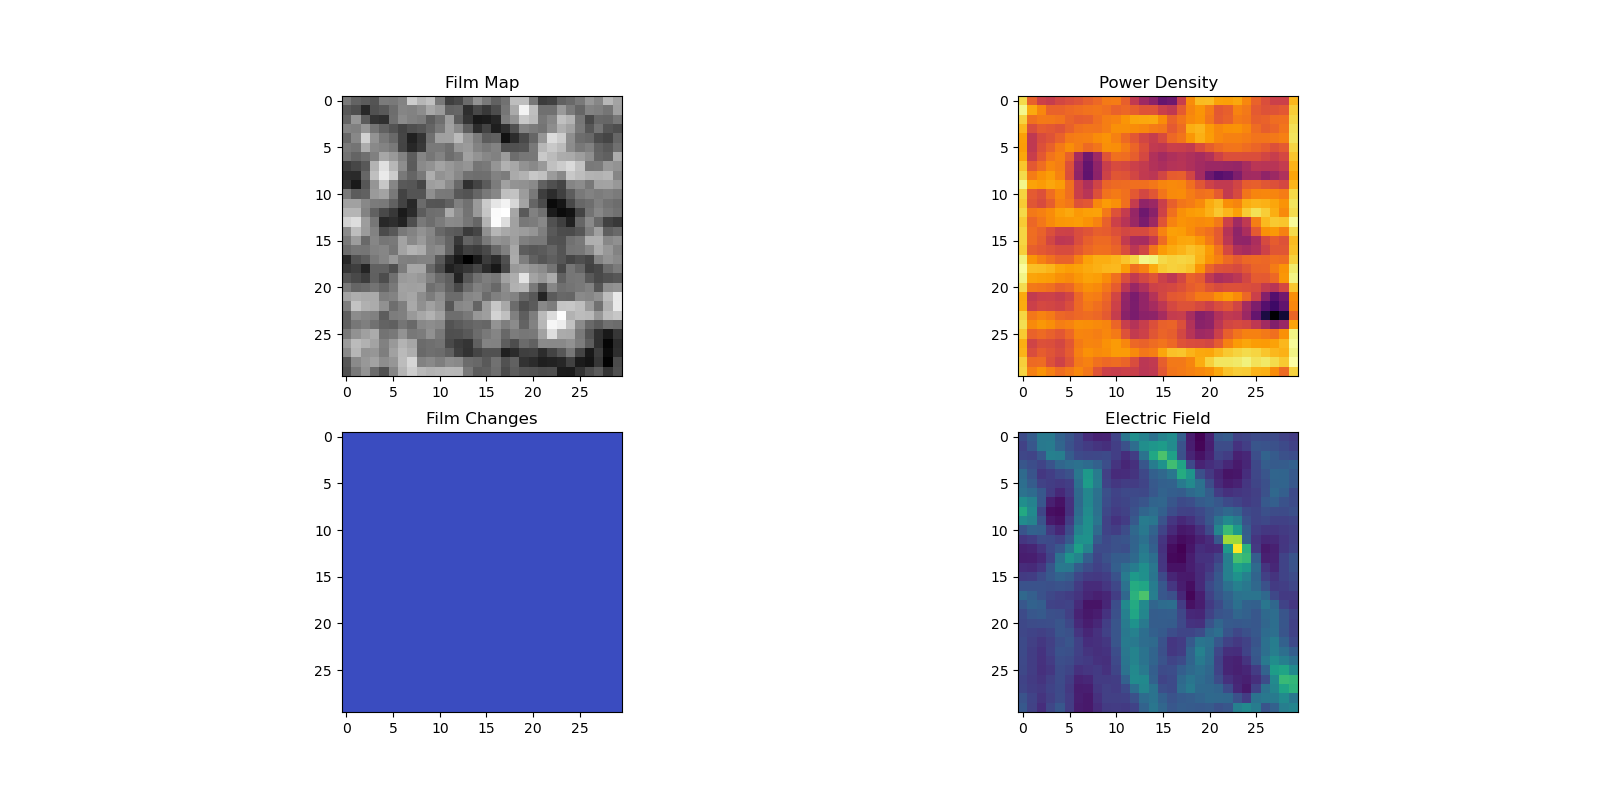

In [10]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from time import sleep

draw_animation = True
save_animation = False

film_steps = [i["film"] for i in maps]
maps_steps = [i for i in maps]

if draw_animation or save_animation:
    film_steps = [image.astype(float) for image in film_steps]
    deltas = [film_steps[i+1] - film_steps[i] for i in range(len(film_steps)-1)]

    fig_anim, axs = plt.subplots(2, 2, figsize=(16, 8))
    axs = axs.flat

    im0 = axs[0].imshow(film_steps[0], cmap='gray')
    axs[0].set_title('Film Map')

    im1 = axs[1].imshow(maps_steps[0]['power_density'], cmap='inferno')
    axs[1].set_title('Power Density')

    im2 = axs[3].imshow(maps_steps[0]['E_field'], cmap='viridis')
    axs[3].set_title('Electric Field')

    im3 = axs[2].imshow(deltas[0], cmap='coolwarm')
    axs[2].set_title('Film Changes')

    def update(frame):
        im0.set_data(film_steps[frame])
        im1.set_data(maps_steps[frame]['power_density'])
        im2.set_data(maps_steps[frame]['E_field'])

        if frame < len(deltas):
            im3.set_data(deltas[frame])
        else:
            im3.set_data(np.zeros_like(deltas[0]))  # No changes after last step

        #sleep(0.2)

        return im0, im1, im2, im3

    ani = FuncAnimation(fig_anim, update, frames=len(film_steps), interval=200, blit=False)
    
    if save_animation:
        ani.save('animation.gif', writer='pillow', fps=5)

    if draw_animation:
        plt.show()
    
    ""